<a href="https://colab.research.google.com/github/mhasan502/Age_Estimation/blob/Jibon/Age_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# custom_loader

## Installing Required Packages

In [430]:
!pip install parse
!pip install decouple

## Importing Required Packages

In [431]:
import os
import sys
import torch
import zipfile
import decouple
from PIL import Image
from parse import parse
from torch.utils.data import DataLoader, Dataset

# zip_pass = decouple.config("ZIP_KEY")

## DataLoader Classes

In [432]:
class AgeDBHandler:
    def __init__(self, datasets_dir, preload=False, device: torch.device = torch.device('cpu')):
        self.device = device
        self.preload = preload

        self.datasets_dir = datasets_dir
        self.directory = os.path.join(datasets_dir, 'AgeDB')
        self.zipFile = os.path.join(datasets_dir, 'AgeDB.zip')

        self.trainDataset = None
        self.testDataset = None
        self.validateDataset = None

        self._prepare_on_disk()
    
    def _prepare_on_disk(self):
        if os.path.exists(self.directory):
            if len(os.listdir(self.directory)) != 0:    # Already directory exists
                return
        
        print('Could not find AgeDB on', self.directory)
        print('Looking for ', self.zipFile)

        if os.path.exists(self.zipFile):

            print(self.zipFile, 'is found. Trying to extract:')
            with zipfile.ZipFile(self.zipFile) as zf:
                zf.extractall(pwd=zip_pass, path=self.datasets_dir)

            print('Successfully extracted')

        else:
            sys.exit('AgeDB Zip file not found!')


In [433]:
class AgeDBDataset(Dataset):
    def __init__(self, directory, transform, preload=False, device: torch.device = torch.device('cpu'), **kwargs):
        self.device = device
        self.directory = directory
        self.transform = transform        
        self.labels = []
        self.images = []
        self.preload = preload
        
        for i, file in enumerate(sorted(os.listdir(self.directory))):
            file_labels = parse('{}_{person}_{age}_{gender}.jpg', file)
            
            if file_labels is None:
                continue
                
            if self.preload:
                image = Image.open(os.path.join(self.directory, file)).convert('RGB')
                if self.transform is not None:
                    image = self.transform(image).to(self.device)

            else:
                image = os.path.join(self.directory, file)

            self.images.append(image)
            gender_to_class_id = {
                'm': 0,
                'f': 1
            }
            gender = gender_to_class_id[file_labels['gender']]
            person = str(file_labels['person'])
            age = int(file_labels['age'])
            self.labels.append({
                'person': person,
                'age': age, 
                'gender': gender
            })

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]

        if not self.preload:
            image = Image.open(image).convert('RGB')
            if self.transform is not None:
                image = self.transform(image).to(self.device)

        labels = {
            'person': self.labels[idx]['person'], 
            'age': self.labels[idx]['age'], 
            'gender': self.labels[idx]['gender']
            }
        return image.to(self.device), labels
    

    def get_loaders(self, batch_size, train_size, test_size, **kwargs):

        train_len = int(len(self) * train_size)
        test_len = int(len(self) * test_size)
        validate_len = len(self) - (train_len + test_len)

        self.trainDataset, self.validateDataset, self.testDataset = torch.utils.data.random_split(
            dataset = self, 
            lengths = [train_len, validate_len, test_len], 
            generator = torch.Generator().manual_seed(42)
        )

        train_loader = DataLoader(self.trainDataset, batch_size=batch_size)
        validate_loader = DataLoader(self.validateDataset, batch_size=batch_size)
        test_loader = DataLoader(self.testDataset, batch_size=batch_size)

        return train_loader, validate_loader, test_loader


# Preprocessing

## Importing Required Packages

In [434]:
from torch import nn
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor, Compose, Scale, Grayscale, Resize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [435]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Loading Dataset

In [436]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [437]:
inside = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/')
for i in range(20):
    print(inside[i])

15588_KateOMara_32_f.jpg
15658_KatharineRoss_68_f.jpg
15741_MaryTamm_40_f.jpg
15661_KatharineRoss_72_f.jpg
15621_KateOMara_70_f.jpg
15646_KatharineRoss_46_f.jpg
15851_StВphaneAudran_22_f.jpg
15810_SarahDouglas_61_f.jpg
15486_JeanetteMacDonald_46_f.jpg
15831_StefaniePowers_56_f.jpg
15670_KathrynGrayson_26_f.jpg
15539_JulieBishop_36_f.jpg
15696_KathrynGrayson_75_f.jpg
15738_MaryTamm_33_f.jpg
15853_StВphaneAudran_24_f.jpg
15665_KathrynGrayson_21_f.jpg
15815_StefaniePowers_24_f.jpg
15748_MaryTamm_51_f.jpg
15759_PamelaSueMartin_26_f.jpg
15799_SarahDouglas_43_f.jpg


In [438]:
sorted_dir = sorted(os.listdir('/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/'))
for i in range(20):
    print(sorted_dir[i])

0_MariaCallas_35_f.jpg
10000_GlennClose_62_f.jpg
10001_GoldieHawn_23_f.jpg
10002_GoldieHawn_24_f.jpg
10003_GoldieHawn_24_f.jpg
10004_GoldieHawn_27_f.jpg
10005_GoldieHawn_28_f.jpg
10006_GoldieHawn_29_f.jpg
10007_GoldieHawn_30_f.jpg
10008_GoldieHawn_31_f.jpg
10009_GoldieHawn_35_f.jpg
1000_StephenHawking_1_m.jpg
10010_GoldieHawn_35_f.jpg
10011_GoldieHawn_37_f.jpg
10012_GoldieHawn_39_f.jpg
10013_GoldieHawn_44_f.jpg
10014_GoldieHawn_45_f.jpg
10015_GoldieHawn_45_f.jpg
10016_GoldieHawn_50_f.jpg
10017_GoldieHawn_51_f.jpg


In [439]:
dataset = AgeDBDataset(
    directory = '/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB',
    transform = Compose([
        Resize((28, 28)),
        Grayscale(num_output_channels=1),
        ToTensor(),
    ]),
    device = device
)

## Dataset Attributes

In [440]:
len(dataset)

16488

In [441]:
dataset[0]

(tensor([[[0.4275, 0.4392, 0.4431, 0.4314, 0.4431, 0.4588, 0.4863, 0.5529,
           0.5412, 0.3608, 0.2667, 0.1922, 0.1490, 0.1176, 0.1098, 0.1529,
           0.1176, 0.2392, 0.4314, 0.5059, 0.5020, 0.4980, 0.4980, 0.4863,
           0.4667, 0.4510, 0.4353, 0.4157],
          [0.4275, 0.4431, 0.4510, 0.4549, 0.4588, 0.4627, 0.6235, 0.8549,
           0.7608, 0.5137, 0.3529, 0.2627, 0.2392, 0.1412, 0.1804, 0.2235,
           0.1137, 0.0980, 0.1176, 0.3255, 0.5216, 0.5294, 0.5373, 0.5255,
           0.5098, 0.4980, 0.4824, 0.4667],
          [0.4314, 0.4471, 0.4588, 0.4627, 0.4706, 0.5725, 0.8745, 0.8902,
           0.8078, 0.5451, 0.2235, 0.1647, 0.2353, 0.2902, 0.3216, 0.3216,
           0.1725, 0.1294, 0.1059, 0.1098, 0.3294, 0.5569, 0.5608, 0.5608,
           0.5569, 0.5451, 0.5294, 0.5137],
          [0.4275, 0.4510, 0.4549, 0.4667, 0.5098, 0.7490, 0.7373, 0.6471,
           0.6157, 0.3647, 0.3098, 0.4196, 0.5569, 0.6667, 0.6667, 0.5725,
           0.3686, 0.2078, 0.1137, 0.0784, 

In [442]:
type(dataset[0])

tuple

In [443]:
dataset.labels[0]

{'age': 35, 'gender': 1, 'person': 'MariaCallas'}

In [444]:
print(dataset.images[0])

/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/0_MariaCallas_35_f.jpg


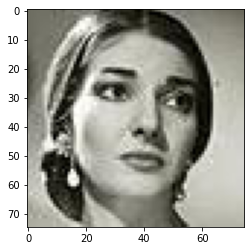

In [445]:
plt.figure()
plt.imshow(plt.imread(dataset.images[0]))

/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/10000_GlennClose_62_f.jpg


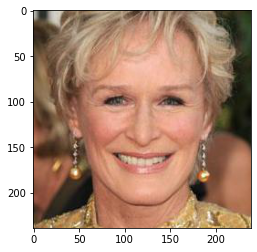

In [446]:
print(dataset.images[1])

plt.figure()
plt.imshow(plt.imread(dataset.images[1]))

In [447]:
dataset.labels[1]

{'age': 62, 'gender': 1, 'person': 'GlennClose'}

249 248
400 400


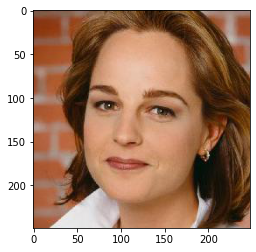

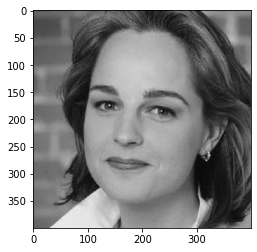

In [448]:
plt.figure()
image = Image.open(dataset.images[48])
plt.imshow((image))
print(image.height, image.width)
image = image.resize(
    size = (400,400),
    resample=Image.LANCZOS,
)
plt.figure()
image = image.convert('LA')
plt.imshow(image)
print(image.height, image.width)

## Data Visualization

In [449]:
age = []
gender = []
for i in range(len(dataset)):
    age.append(dataset.labels[i]['age'])
    gender.append(dataset.labels[i]['gender'])

In [450]:
print("Highest Age Value: "+str(max(age))+"\nLowest Age Value: "+str(min(age)))

Highest Age Value: 101
Lowest Age Value: 1


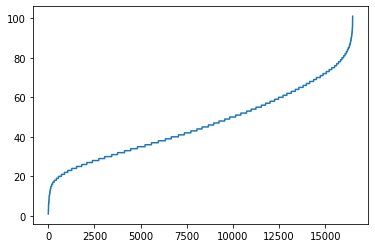

In [451]:
plt.plot(sorted(age))
plt.show()

In [452]:
listofzeros = [0] * len(dataset)
same_age = [i for i in range(min(age), max(age) + 1)]

age_number = dict(zip(same_age, listofzeros))
copy_age = age_number.copy()
age_number

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0}

In [453]:
for i in range(len(dataset)):
    if dataset.labels[i]['age'] in age_number:
        age_number[dataset.labels[i]['age']] += 1
    
age_number

{1: 1,
 2: 0,
 3: 8,
 4: 2,
 5: 4,
 6: 8,
 7: 11,
 8: 8,
 9: 6,
 10: 13,
 11: 20,
 12: 14,
 13: 22,
 14: 23,
 15: 43,
 16: 52,
 17: 82,
 18: 120,
 19: 110,
 20: 161,
 21: 163,
 22: 183,
 23: 212,
 24: 259,
 25: 284,
 26: 275,
 27: 304,
 28: 347,
 29: 313,
 30: 385,
 31: 316,
 32: 378,
 33: 338,
 34: 362,
 35: 413,
 36: 347,
 37: 370,
 38: 382,
 39: 321,
 40: 386,
 41: 320,
 42: 356,
 43: 325,
 44: 281,
 45: 342,
 46: 287,
 47: 289,
 48: 311,
 49: 267,
 50: 317,
 51: 287,
 52: 310,
 53: 250,
 54: 258,
 55: 294,
 56: 227,
 57: 243,
 58: 246,
 59: 213,
 60: 245,
 61: 207,
 62: 238,
 63: 218,
 64: 193,
 65: 231,
 66: 177,
 67: 177,
 68: 215,
 69: 150,
 70: 216,
 71: 145,
 72: 175,
 73: 156,
 74: 138,
 75: 158,
 76: 109,
 77: 104,
 78: 106,
 79: 76,
 80: 91,
 81: 76,
 82: 68,
 83: 57,
 84: 43,
 85: 58,
 86: 35,
 87: 30,
 88: 21,
 89: 19,
 90: 19,
 91: 17,
 92: 11,
 93: 15,
 94: 7,
 95: 9,
 96: 2,
 97: 1,
 98: 2,
 99: 1,
 100: 2,
 101: 1}

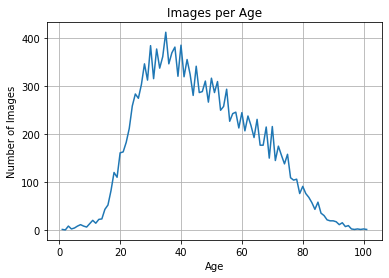

In [454]:
age_amount = age_number.items()
x, y = zip(*age_amount)

plt.plot(x, y)
plt.title("Images per Age")
plt.xlabel("Age")
plt.ylabel("Number of Images")

plt.grid()
plt.show()  

In [455]:
num_gender = {0: 0, 1: 0}
for i in range(len(dataset)):                         # {'m': 0, 'f': 1}
    if dataset.labels[i]['gender'] in num_gender:
        num_gender[dataset.labels[i]['gender']] += 1
    
num_gender

{0: 9788, 1: 6700}

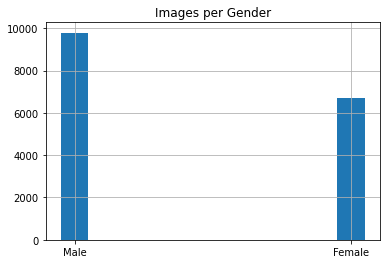

In [456]:
gender_amount = num_gender.items()
_, y = zip(*gender_amount)

plt.title("Images per Gender")

plt.grid()
plt.bar(['Male', 'Female'], y, width = 0.1)
plt.show()  

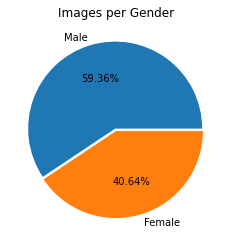

In [457]:
gender_amount = num_gender.items()
_, y = zip(*gender_amount)

plt.title("Images per Gender")
mylabels = ["Male", "Female"]
myexplode = [0.03, 0]

plt.grid()
plt.pie(y, labels = mylabels, explode = myexplode, autopct='%1.2f%%')
plt.show() 

In [458]:
people = []
for i in range(len(dataset)):
    if dataset.labels[i]['person'] not in people:
        people.append(dataset.labels[i]['person'])
sorted(people)

['AbeVigoda',
 'AdolfHitlerr',
 'AlCorley',
 'AlKapone',
 'AlPacino',
 'AlainDelon',
 'AlanRickman',
 'AlanYoung',
 'AlbertCamus',
 'AlbertSchweitzer',
 'AlbertoSordi',
 'AlecGuinness',
 'AlejandroRey',
 'AlexanderGrahamBell',
 'AlexandrakisAlekos',
 'AliMacGraw',
 'AlikiBoug',
 'AmandaBlake',
 'AmandaRedman',
 'AndreMarieAmpКre',
 'AndreasPapantreou',
 'AndyGriffith',
 'AngelaLansbury',
 'AngieDickinson',
 'AnitaEkberg',
 'AnjelicaHuston',
 'AnnJillian',
 'AnnMargret',
 'AnnMiller',
 'AnnaMassey',
 'AnneBancroft',
 'AnneBaxter',
 'AnnetteBening',
 'AnnieGirardot',
 'AnthonyAndrews',
 'AnthonyHopkins',
 'AnthonyPerkins',
 'AnthonyQuayle',
 'Arletty',
 'ArmandAssante',
 'ArnoldSchwarzenegger',
 'AudreyHepburn',
 'AvaGardner',
 'BarbaraBain',
 'BarbaraBouchet',
 'BarbaraStanwyck',
 'BarbraStreisand',
 'BeaArthur',
 'BenGazzara',
 'BernadetteLafont',
 'BerryGordy',
 'BertrandRussell',
 'BetteDavis',
 'BetteMidler',
 'BettyGarrett',
 'BettyGrable',
 'BeverlyRoberts',
 'BillCosby',
 'BillMu

In [459]:
len(people)

567

In [460]:
male_age = copy_age.copy()
female_age = copy_age.copy()

for i in range(len(dataset)):                         # {'m': 0, 'f': 1}
    if dataset.labels[i]['gender'] == 0:
        male_age[dataset.labels[i]['age']] += 1
    elif dataset.labels[i]['gender'] == 1:
        female_age[dataset.labels[i]['age']] += 1
    else:
        print("Something is not right")
    
male_age

{1: 1,
 2: 0,
 3: 6,
 4: 1,
 5: 2,
 6: 2,
 7: 7,
 8: 4,
 9: 2,
 10: 10,
 11: 10,
 12: 7,
 13: 6,
 14: 9,
 15: 16,
 16: 22,
 17: 37,
 18: 49,
 19: 38,
 20: 68,
 21: 51,
 22: 70,
 23: 80,
 24: 111,
 25: 119,
 26: 116,
 27: 140,
 28: 169,
 29: 159,
 30: 213,
 31: 164,
 32: 211,
 33: 176,
 34: 209,
 35: 243,
 36: 204,
 37: 234,
 38: 246,
 39: 196,
 40: 242,
 41: 197,
 42: 227,
 43: 203,
 44: 184,
 45: 227,
 46: 178,
 47: 175,
 48: 203,
 49: 168,
 50: 206,
 51: 190,
 52: 218,
 53: 164,
 54: 177,
 55: 189,
 56: 149,
 57: 170,
 58: 162,
 59: 139,
 60: 164,
 61: 137,
 62: 161,
 63: 144,
 64: 119,
 65: 172,
 66: 118,
 67: 119,
 68: 146,
 69: 98,
 70: 144,
 71: 89,
 72: 118,
 73: 100,
 74: 95,
 75: 103,
 76: 68,
 77: 61,
 78: 63,
 79: 51,
 80: 60,
 81: 48,
 82: 40,
 83: 36,
 84: 23,
 85: 30,
 86: 16,
 87: 18,
 88: 12,
 89: 12,
 90: 10,
 91: 9,
 92: 8,
 93: 9,
 94: 4,
 95: 6,
 96: 0,
 97: 1,
 98: 0,
 99: 0,
 100: 0,
 101: 0}

In [461]:
female_age

{1: 0,
 2: 0,
 3: 2,
 4: 1,
 5: 2,
 6: 6,
 7: 4,
 8: 4,
 9: 4,
 10: 3,
 11: 10,
 12: 7,
 13: 16,
 14: 14,
 15: 27,
 16: 30,
 17: 45,
 18: 71,
 19: 72,
 20: 93,
 21: 112,
 22: 113,
 23: 132,
 24: 148,
 25: 165,
 26: 159,
 27: 164,
 28: 178,
 29: 154,
 30: 172,
 31: 152,
 32: 167,
 33: 162,
 34: 153,
 35: 170,
 36: 143,
 37: 136,
 38: 136,
 39: 125,
 40: 144,
 41: 123,
 42: 129,
 43: 122,
 44: 97,
 45: 115,
 46: 109,
 47: 114,
 48: 108,
 49: 99,
 50: 111,
 51: 97,
 52: 92,
 53: 86,
 54: 81,
 55: 105,
 56: 78,
 57: 73,
 58: 84,
 59: 74,
 60: 81,
 61: 70,
 62: 77,
 63: 74,
 64: 74,
 65: 59,
 66: 59,
 67: 58,
 68: 69,
 69: 52,
 70: 72,
 71: 56,
 72: 57,
 73: 56,
 74: 43,
 75: 55,
 76: 41,
 77: 43,
 78: 43,
 79: 25,
 80: 31,
 81: 28,
 82: 28,
 83: 21,
 84: 20,
 85: 28,
 86: 19,
 87: 12,
 88: 9,
 89: 7,
 90: 9,
 91: 8,
 92: 3,
 93: 6,
 94: 3,
 95: 3,
 96: 2,
 97: 0,
 98: 2,
 99: 1,
 100: 2,
 101: 1}

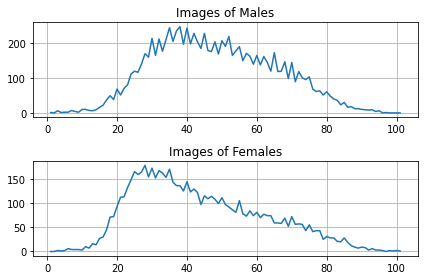

In [462]:
#plot 1:
male_amount = male_age.items()
x, y = zip(*male_amount)

plt.subplot(2, 1, 1)
plt.grid()
plt.plot(x,y)
plt.title("Images of Males")

#plot 2:
female_amount = female_age.items()
x, y = zip(*female_amount)

plt.subplot(2, 1, 2)
plt.grid()
plt.plot(x,y)
plt.title("Images of Females")

plt.tight_layout()
plt.show()

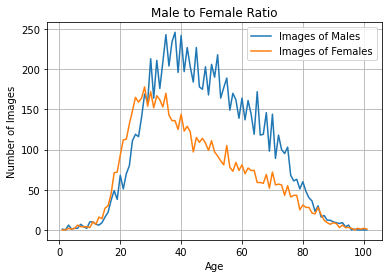

In [463]:
#plot 1:
male_amount = male_age.items()
x1, y1 = zip(*male_amount)

#plot 2:
female_amount = female_age.items()
x2, y2 = zip(*female_amount)

plt.plot(x1, y1)
plt.plot(x2, y2)

plt.legend(["Images of Males", "Images of Females"])

plt.title("Male to Female Ratio")
plt.xlabel("Age")
plt.ylabel("Number of Images")

plt.grid()

plt.show()

# Training Testing

## Importing Required Packages

In [464]:
from torchvision.transforms import transforms

## Split Dataset

In [465]:
dataset[0][0][0][0][0]

tensor(0.4275, device='cuda:0')

In [466]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-373c1ab8-5b21-8f99-6d41-31bca770a0f9)


In [467]:
shapes = []
for i in range(100):   # len(dataset)
    shapes.append(plt.imread(dataset.images[i]).shape)
    print(i, shapes[i])

0 (75, 75, 3)
1 (239, 239, 3)
2 (184, 184, 3)
3 (366, 366)
4 (302, 292, 3)
5 (467, 467, 3)
6 (233, 233, 3)
7 (284, 284, 3)
8 (299, 298, 3)
9 (171, 171, 3)
10 (198, 198, 3)
11 (90, 90, 3)
12 (190, 190, 3)
13 (144, 144, 3)
14 (152, 152, 3)
15 (139, 139, 3)
16 (275, 275, 3)
17 (224, 224, 3)
18 (122, 122, 3)
19 (246, 252, 3)
20 (195, 196, 3)
21 (126, 126, 3)
22 (353, 353)
23 (122, 122, 3)
24 (413, 412, 3)
25 (133, 133, 3)
26 (154, 154, 3)
27 (184, 184, 3)
28 (166, 165, 3)
29 (203, 204, 3)
30 (126, 126, 3)
31 (62, 63, 3)
32 (201, 191, 3)
33 (323, 269, 3)
34 (163, 163, 3)
35 (305, 267, 3)
36 (182, 182, 3)
37 (352, 355, 3)
38 (120, 121, 3)
39 (213, 212, 3)
40 (136, 137, 3)
41 (186, 186, 3)
42 (114, 114, 3)
43 (214, 215, 3)
44 (116, 117, 3)
45 (309, 310, 3)
46 (330, 330, 3)
47 (216, 216, 3)
48 (249, 248, 3)
49 (193, 193, 3)
50 (176, 177, 3)
51 (121, 120, 3)
52 (171, 171, 3)
53 (166, 166, 3)
54 (152, 152, 3)
55 (425, 424, 3)
56 (248, 248, 3)
57 (185, 185, 3)
58 (201, 201, 3)
59 (156, 155, 3)
60

In [468]:
max(shapes), min(shapes)

((467, 467, 3), (62, 63, 3))

In [469]:
# hyper params

input_size = 28
hidden_unit = 28
num_of_class = 100
learning_rate = 0.001
batch_size = 64
num_of_epoch = 10

In [470]:
train_set, validation_set, test_set = dataset.get_loaders(
    batch_size = batch_size,
    train_size=0.7,
    test_size=0.2,
)

In [471]:
len(train_set), len(validation_set), len(test_set)

(181, 26, 52)

In [472]:
sum = len(train_set) + len(validation_set) + len(test_set)
sum == len(dataset)

False

In [473]:
img, lbl = iter(train_set).next()

In [474]:
img.shape, lbl['age'].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## Simple Model

In [475]:
# define the model

class AGEModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_of_class):
        super(AGEModel, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, num_of_class)

    def forward(self, x):
        out = self.input(x)
        out = self.relu(out)
        out = self.output(out)
        out = out.reshape(out.size(0), -1) #add

        return out

In [476]:
model = AGEModel(input_size = input_size,
                 hidden_size = hidden_unit,
                 num_of_class = num_of_class).to(device)

In [477]:
criteria  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [496]:
#write the training loop

def train(model, optimizer, criterion, train_loader, num_of_epoch):
    print("hi")
    total_step = len(train_loader)
    print(total_step)
    for epoch in range(num_of_epoch):
        print(epoch)

        for i, (imgs, labels) in enumerate(train_loader):
            print(i)
            imgs = imgs.to(device)
            #ages = torch.as_tensor(labels['age']).to(device)
            genders = torch.as_tensor(labels['gender']).to(device)
            
            outputs = model(imgs)
            #loss = criterion(outputs, ages)
            loss = criterion(outputs, genders)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            if (i + 1) % total_step  == 0:  
                print(f'EPOCH: {epoch+1}/{num_of_epoch}, STEP: {i+1}/{total_step}, LOSS: {loss.item()}')


In [497]:
train(model, optimizer, criteria , train_set, num_of_epoch)

hi
181
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
EPOCH: 1/10, STEP: 181/181, LOSS: 3.2523512840270996
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


In [504]:

def eval(model, test_loader):
    model.eval()
    #a = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for imgs, labels in test_loader:
            #a += 1
            #print(a)
            imgs = imgs.to(device)
            #ages = torch.as_tensor(labels['age']).to(device)
            genders = torch.as_tensor(labels['gender']).to(device)
            outputs = model(imgs)
            #labels = labels.to(device)
            #outputs = model(imgs)

            _, pred = torch.max(outputs.data, 1)
            #total += ages.size(0)
            #correct += (pred == ages).sum().item()
            total += genders.size(0)
            correct += (pred == genders).sum().item()

    print(f"ACC: {(100*correct)/total}%")
    print("C: ", correct, " T:", total)

In [505]:
eval(model, test_set) 

1
2
3
4


KeyboardInterrupt: ignored